In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import scipy.sparse as sps
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from tqdm.auto import tqdm
from datetime import datetime

In [2]:
idx_ver = 1 
R = 10
alpha_fixed = 0.05
delta_fixed = 0.0
l_fixed = 10.0
Nmax = 3650
rf_source = 'KR_LS'

In [3]:
dir_in_raw = './KR_ret_models/ret_curve_R_{}_alpha_{}_ridge_{}_RF_{}_daily_ver_{}/'\
    .format(R, alpha_fixed, l_fixed, rf_source, idx_ver)

dir_out_measure = './complexity_measures/complexity_measures/'
if not os.path.exists(dir_out_measure):
    os.makedirs(dir_out_measure)
    
# load prices 
dir_B = './B_and_C/B_max_ttm_10yr/'
B_mat = np.load(dir_B + 'B_mat.npy')
Bc_shift_mat = np.load(dir_B + 'Bc_shift_mat.npy')
with open(dir_B + "dict_par.pkl", "rb") as handle:
    dict_par = pickle.load(handle)
nmax,Nmax,prefix_C,dir_npz = [dict_par[key] for key in ['nmax','Nmax','prefix_C','npz_dir']]

# load daily lookup table
df_t_lookup_daily = pd.read_pickle(dir_B+'df_t_lookup_{}.pkl'.format('daily'))
df_t_lookup_daily = df_t_lookup_daily.iloc[:-1]
T = len(df_t_lookup_daily)
date_index = df_t_lookup_daily.index

# load mask
dir_mask = './mask/'
mat_mask_maturity = np.load(dir_mask+'mat_filter_maturity_90days.npy')
mat_nt = np.load(dir_mask + 'mat_nt.npy')
mat_ytm = np.load(dir_mask + 'mat_ytm.npy')

# load daily risk-free rate
df_rf = pd.read_pickle('./data_supplement/df_riskfree_daily_all.pkl').KR_LS

# Calculate RMSE in excess return if no model is fitted

In [5]:
### get rmse in rx if no model is fitted

pbar = tqdm(total=T)
rmse = np.full(T, np.nan)

df_t_lookup_daily_nocut = pd.read_pickle(dir_B+'df_t_lookup_{}.pkl'.format('daily'))
T_nocut = len(df_t_lookup_daily_nocut)

for t_freq in range(T):
    t = df_t_lookup_daily.iloc[t_freq].t
    today = df_t_lookup_daily.index[t_freq]
    today_str = today.strftime('%Y-%m-%d')

    date_s = (df_t_lookup_daily_nocut.index[t+1]-df_t_lookup_daily_nocut.index[t]).days
    B = B_mat[:,t]
    nt = int(mat_nt[t])

    # filter step
    mask_keep = mat_mask_maturity[t,:nt]
    mask_keep = np.logical_and(mask_keep, mat_ytm[t,:nt] < 0.25) 

    # remove empty rows from B
    # apply filter
    B = B[:nt][mask_keep]
    Bc_shift = Bc_shift_mat[:nt,t][mask_keep]
    nt = len(B)

    # normalize prices to 1
    Bc_shift = (1/B)*Bc_shift
    # C=(1/B)[:,np.newaxis]*C
    B = np.ones(nt)*1

    # get return of securities
    rf = (1+df_rf.loc[today_str])**date_s-1 # scalar
    ret = (Bc_shift-B)/B
    rx = ret-rf
    
    rmse[t_freq] = np.sqrt(np.mean(rx**2))
    
    pbar.update(1)


  0%|          | 0/15366 [00:00<?, ?it/s]

# Calculate RMSE of R-factor model

In [6]:
# get rmse of factor model when R factors are included
# rmse of fitting rx of securities
# the last col is for full model
mat_rmse_fm = np.full((T, R+1), np.nan)

pbar = tqdm(total=T)
for t_freq in range(T):
    t = df_t_lookup_daily.iloc[t_freq].t
    with open(dir_in_raw+'dict_ret_curve_tfreq_{}_t_{}.pkl'.format(t_freq,t),\
              "rb") as handle:
        dict_t = pickle.load(handle) 
        
    for idx_R in range(R):
        r = idx_R+1
        mat_rmse_fm[t_freq, idx_R] = dict_t['dict_fm'][r]['rmse_fm']
    mat_rmse_fm[t_freq, R] = dict_t['dict_full']['rmse']
    pbar.update(1)
    
columns = ['KR-{}'.format(x) for x in range(1,1+R)]+['KR-Full']
df_rmse_fm = pd.DataFrame(data=mat_rmse_fm, index=date_index, columns=columns)

# explained variation by the first R factors
df_ev = pd.DataFrame(data=1-(df_rmse_fm**2).values/rmse[:,np.newaxis]**2,
                      index=date_index,
                      columns=columns)

  0%|          | 0/15366 [00:00<?, ?it/s]

In [7]:
key = 'KR-4' 

### IT-VOL
df_itvol = 1 - df_ev[key]

### T-COM
df_tcom = (1 - df_ev['KR-1']) - (1 - df_ev[key])

In [8]:
df_comp = pd.concat((df_itvol,df_tcom),axis=1)
df_comp.columns = ['IT-VOL','T-COM']
display(df_comp.head())

df_comp.to_pickle('./complexity_measures/df_comp.pkl')

,IT-VOL,T-COM
1961-06-14,0.102694,0.050492
1961-06-15,0.705777,0.244374
1961-06-16,0.145966,0.075316
1961-06-19,0.200142,0.137031
1961-06-20,0.353264,0.022315


# Plot IT-VOL, T-COM

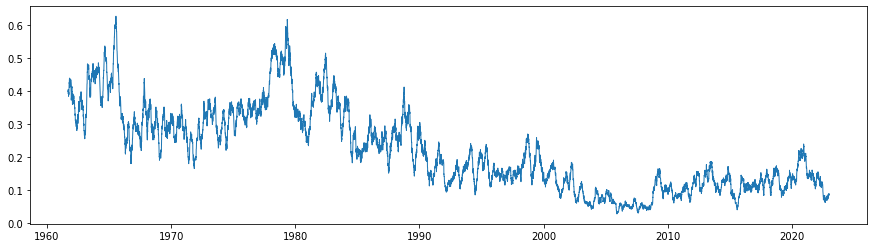

In [11]:
### IT-VOL: Idiosyncratic treasury volatility measures
### 3M MA
rolling_mon = 3
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
ax.grid(False)

ax.plot(df_itvol.rolling(21*rolling_mon).mean(),linewidth=1)
plt.show()

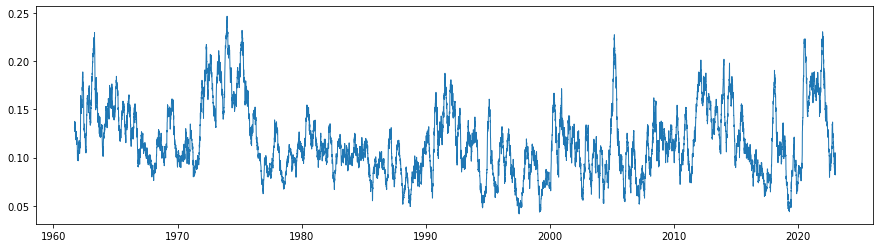

In [10]:
### T-COM: Treasury Market Complexity
### 3M MA
rolling_mon = 3
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
ax.grid(False)
ax.plot(df_tcom.rolling(21*rolling_mon).mean(),linewidth=1)
plt.show()